<a href="https://colab.research.google.com/github/Victor-techh/solutions-data-analysis/blob/main/Projeto_Churn_Olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import sqlite3
import os
from google.colab import drive

# 1. Conectar ao Drive e definir caminhos
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Projeto_Olist/'

# 2. Carregar os CSVs do Drive para a memória (Define as variáveis)
try:
    print("⏳ Carregando arquivos do Drive...")
    df_orders = pd.read_csv(path + 'olist_orders_dataset.csv', sep=';')
    df_items = pd.read_csv(path + 'olist_order_items_dataset.csv', sep=',')
    df_customers = pd.read_csv(path + 'olist_customers_dataset.csv', sep=',')

    # AJUSTE ESSENCIAL: Convertendo as 3 colunas de data necessárias
    colunas_data = [
        'order_purchase_timestamp',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ]

    for col in colunas_data:
        # errors='coerce' transforma datas inválidas em "vazio" (NaT) em vez de dar erro
        df_orders[col] = pd.to_datetime(df_orders[col], dayfirst=True, errors='coerce')

    print("✅ Arquivos carregados e DATAS corrigidas na memória!")

    # Salvando no Banco de Dados Persistente
    conn = sqlite3.connect(path + 'olist_projeto_final.db')
    df_orders.to_sql('orders', conn, if_exists='replace', index=False)
    df_items.to_sql('items', conn, if_exists='replace', index=False)
    df_customers.to_sql('customers', conn, if_exists='replace', index=False)
    print("💾 Banco 'olist_projeto_final.db' atualizado com as datas corretas!")

except Exception as e:
    print(f"❌ Erro na carga: {e}")

Mounted at /content/drive
⏳ Carregando arquivos do Drive...
✅ Arquivos carregados e DATAS corrigidas na memória!
💾 Banco 'olist_projeto_final.db' atualizado com as datas corretas!


Os dados utilizados são oficiais e foram disponibilizados publicamente pela empresa através do Kaggle (Brazilian E-Commerce Public Dataset by Olist). O objetivo é diagnosticar as causas de uma taxa de Churn elevada através da ótica logística e financeira.


--- DISTRIBUIÇÃO DE CHURN ---
Ativo: 9 clientes (0.01%)
Alerta: 9684 clientes (9.74%)
Churn: 89748 clientes (90.25%)


/tmp/ipython-input-2012845374.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem.index, y=contagem.values, palette='viridis')


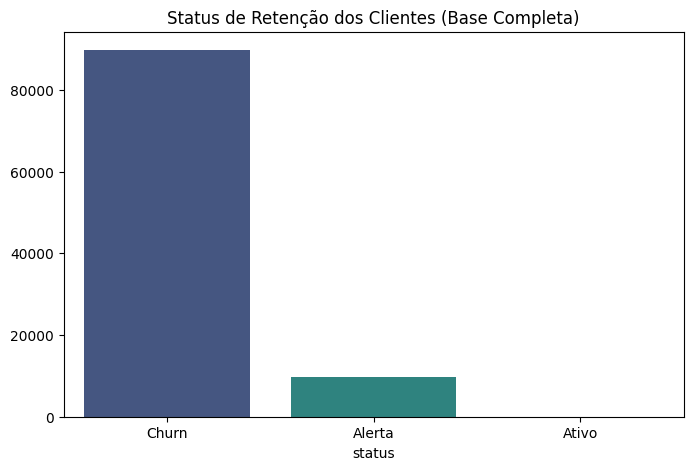

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cálculo de Churn via SQL
query_churn = """
SELECT
    customer_id,
    MAX(order_purchase_timestamp) AS ultima_compra,
    CAST(JULIANDAY('2018-10-18') - JULIANDAY(MAX(order_purchase_timestamp)) AS INT) AS dias_sem_comprar
FROM orders
GROUP BY customer_id
"""
df_churn = pd.read_sql(query_churn, conn)

# 2. Classificação
def rotular(dias):
    if dias <= 30: return 'Ativo'
    elif dias <= 90: return 'Alerta'
    else: return 'Churn'

df_churn['status'] = df_churn['dias_sem_comprar'].apply(rotular)

# 3. Resultados e Gráfico
contagem = df_churn['status'].value_counts()
porcentagem = df_churn['status'].value_counts(normalize=True) * 100

print("--- DISTRIBUIÇÃO DE CHURN ---")
for s in ['Ativo', 'Alerta', 'Churn']:
    print(f"{s}: {contagem[s]} clientes ({porcentagem[s]:.2f}%)")

plt.figure(figsize=(8, 5))
sns.barplot(x=contagem.index, y=contagem.values, palette='viridis')
plt.title('Status de Retenção dos Clientes (Base Completa)')
plt.show()

Acima temos o tamanho do Churn da operação.

Os dados mostram que o Churn está na casa dos 90%, o que evidencia a enorme dificuldade de fidelizar clientes. Esse índice indica que a vasta maioria da base não realiza uma nova compra há mais de 90 dias.

O grupo em Alerta (9%) representa clientes que ainda são considerados da base, mas que não compram há mais de 30 dias, indicando um risco iminente de perda caso não haja uma ação de retenção.

Por fim, a taxa de 0,01% de clientes Ativos é o dado mais alarmante: ele revela que apenas uma fração mínima da base realizou compras nos últimos 30 dias. Mais do que apenas '9 clientes', esse número prova que a Olist sobrevive de atrair constantemente novos consumidores, mas falha em mantê-los ativos após a primeira experiência.


/tmp/ipython-input-3241948694.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_logistica, x='customer_state', y='pct_frete_medio', ax=ax[0], palette='coolwarm')
/tmp/ipython-input-3241948694.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_logistica, x='customer_state', y='media_atraso_dias', ax=ax[1], palette='Reds_r')


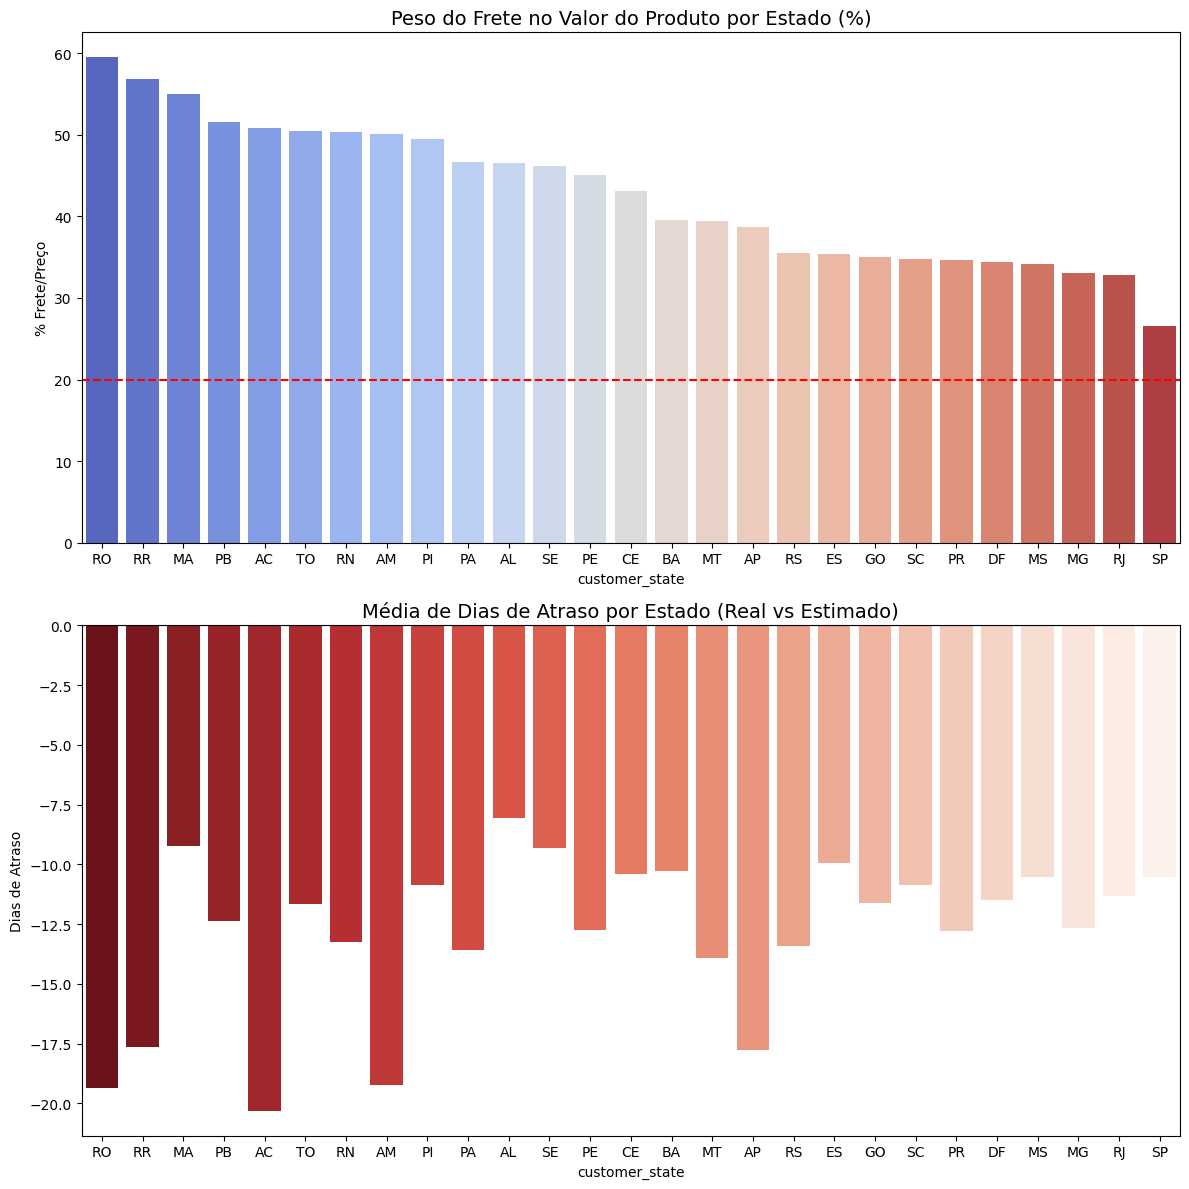

--- ESTADOS COM MAIOR IMPACTO LOGÍSTICO (FRETE + ATRASO) ---
  customer_state  pct_frete_medio  media_atraso_dias
0             RO        59.576108         -19.341484
1             RR        56.827791         -17.618765
2             MA        54.990936          -9.225428
3             PB        51.525824         -12.371969
4             AC        50.831149         -20.333219


In [5]:
# 1. Query SQL: Unindo Frete, Atrasos e Localização
query_logistica = """
SELECT
    c.customer_state,
    AVG((i.freight_value / i.price) * 100) AS pct_frete_medio,
    AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date)) AS media_atraso_dias
FROM orders o
JOIN items i ON o.order_id = i.order_id
JOIN customers c ON o.customer_id = c.customer_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
GROUP BY c.customer_state
ORDER BY pct_frete_medio DESC
"""

df_logistica = pd.read_sql(query_logistica, conn)

# 2. Visualização Dupla
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Gráfico A: Peso do Frete por Estado
sns.barplot(data=df_logistica, x='customer_state', y='pct_frete_medio', ax=ax[0], palette='coolwarm')
ax[0].axhline(20, color='red', linestyle='--', label='Limite Crítico (20%)')
ax[0].set_title('Peso do Frete no Valor do Produto por Estado (%)', fontsize=14)
ax[0].set_ylabel('% Frete/Preço')

# Gráfico B: Atrasos Médios por Estado
sns.barplot(data=df_logistica, x='customer_state', y='media_atraso_dias', ax=ax[1], palette='Reds_r')
ax[1].axhline(0, color='black', linestyle='-')
ax[1].set_title('Média de Dias de Atraso por Estado (Real vs Estimado)', fontsize=14)
ax[1].set_ylabel('Dias de Atraso')

plt.tight_layout()
plt.show()

# 3. Exibição dos 5 estados mais críticos
print("--- ESTADOS COM MAIOR IMPACTO LOGÍSTICO (FRETE + ATRASO) ---")
print(df_logistica.head(5))

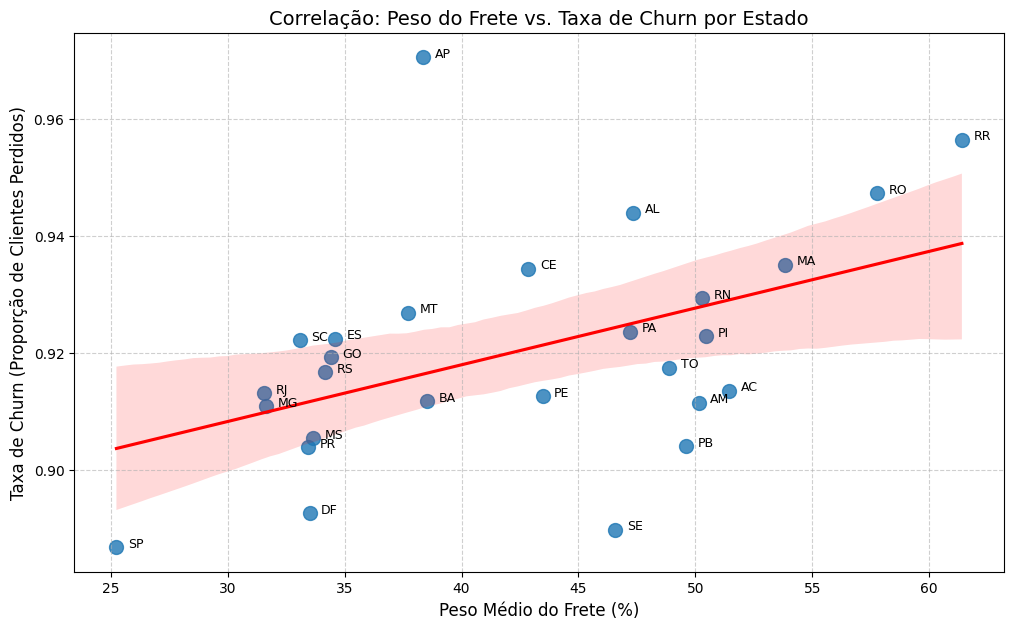

Coeficiente de Correlação de Pearson: 0.47


In [4]:
#Correlação Frete vs. Churn por Estado

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SQL: Buscando dados de Churn, Frete e Estado em uma única visão
query_correlacao = """
SELECT
    c.customer_state,
    o.customer_id,
    MAX(o.order_purchase_timestamp) AS ultima_compra,
    AVG((i.freight_value / i.price) * 100) AS pct_frete
FROM orders o
JOIN items i ON o.order_id = i.order_id
JOIN customers c ON o.customer_id = c.customer_id
WHERE i.price > 0
GROUP BY o.customer_id
"""
df_corr = pd.read_sql(query_correlacao, conn)

# 2. Definindo quem é Churn (Mais de 90 dias sem comprar)
df_corr['is_churn'] = df_corr['ultima_compra'].apply(
    lambda x: 1 if (pd.to_datetime('2018-10-18') - pd.to_datetime(x)).days > 90 else 0
)

# 3. Agrupando por Estado para ver a Correlação
df_estado = df_corr.groupby('customer_state').agg({
    'pct_frete': 'mean',
    'is_churn': 'mean' # Isso gera a % de churn por estado
}).reset_index()

# 4. Gráfico de Dispersão (Scatter Plot)
plt.figure(figsize=(12, 7))
sns.regplot(data=df_estado, x='pct_frete', y='is_churn', scatter_kws={'s':100}, line_kws={"color": "red"})

# Adicionando os nomes dos estados nos pontos
for i in range(df_estado.shape[0]):
    plt.text(df_estado.pct_frete[i]+0.5, df_estado.is_churn[i],
             df_estado.customer_state[i], fontsize=9)

plt.title('Correlação: Peso do Frete vs. Taxa de Churn por Estado', fontsize=14)
plt.xlabel('Peso Médio do Frete (%)', fontsize=12)
plt.ylabel('Taxa de Churn (Proporção de Clientes Perdidos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 5. Cálculo Matemático da Correlação (Coeficiente de Pearson)
correlacao = df_estado['pct_frete'].corr(df_estado['is_churn'])
print(f"Coeficiente de Correlação de Pearson: {correlacao:.2f}")

O Paradoxo Logístico

Identificamos uma estratégia de "Prazos Gordos", onde a empresa estima prazos longos e entrega muito antes do previsto (chegando a 20 dias de antecedência no Norte). Contudo, a análise de correlação prova que a agilidade não compensa o custo: o frete representa até 60% do valor do produto em estados como RO e RR.

Veredito

O Churn é impulsionado pelo Custo Brasil. A experiência de entrega é positiva em termos de tempo, mas a barreira financeira do frete impede que o comprador de oportunidade se torne um cliente recorrente.